In [252]:
import pandas as pd
import string



#from sklearn import decomposition, ensemble

#from tensorflow.keras.preprocessing import text, sequence
#from tensorflow.keras import layers, models, optimizers

from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, naive_bayes, metrics

In [2]:
df = pd.read_csv('./Data/restaurant_data')
target_df = pd.read_csv('./Data/target_data')

restaurants_df = df.merge(target_df,
                         how = 'inner',
                         left_on = ['Unnamed: 0'],
                         right_on = ['Unnamed: 0']
                         )

restaurants_df.drop('Unnamed: 0' , axis=1,inplace =True)

#### The data is loaded to this new notebook for further analysis. A new dataframe corpus2 is created to contain only the review and target.

In [238]:
restaurants_df.head()

,user_id,prod_id,rating,date,review,name,target
0,22558,859,5.0,2007-05-28,Looking for some authentic Japanese food at re...,Yakitori Totto,1
1,78837,915,4.0,2009-10-05,Pepe Rosso is where you go when you're in SOHO...,Pepe Rosso To Go,1
2,19590,668,5.0,2013-09-17,I had waited to return a couple other times to...,Eataly NYC,1
3,7175,287,3.0,2013-10-30,This place is always busy - partly because it'...,Heidi’s House,1
4,137409,744,5.0,2014-12-04,Love this place! I am not a regular yelper I d...,Bodhi Tree,0


In [4]:
corpus2 = restaurants_df[['review','target']]

In [240]:
corpus2.head()

,review,target
0,Looking for some authentic Japanese food at re...,1
1,Pepe Rosso is where you go when you're in SOHO...,1
2,I had waited to return a couple other times to...,1
3,This place is always busy - partly because it'...,1
4,Love this place! I am not a regular yelper I d...,0


#### added new most common words in both the truth and fraud reviews to the stopword to remove the top four words.

In [8]:
sw = stopwords.words('english')

In [9]:
sw += ['food','place','good',"great"]

In [10]:
body = corpus2.review
target = corpus2.target

In [11]:
X_train, X_test, y_train, y_test = train_test_split(body,
                                                    target,
                                                    random_state = 42,
                                                    stratify = target)

In [237]:
#encoded for potential NN usage 
encoder = preprocessing.LabelEncoder()

In [14]:
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

#### Two methods are initiated to clean the text. The first is the count vecorizer used prior and the other is the tfidf vectorizer.

In [15]:
count_vect = CountVectorizer(analyzer='word',stop_words = sw)
count_vect.fit(X_train)

all_words_dict = (count_vect.vocabulary_)

Xtrain_count =  count_vect.transform(X_train)
#Xtest_count =  count_vect.transform(X_test)

In [18]:
X_test_count = count_vect.transform(X_test)

#### Different conditions were tested for the tfidf which scored slightly higher compared to the count vectorizer so this method was the preferred choice. These models have had the imbalnace taken care of and SMOTE will be used in the gridsearch.

In [48]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=5000,lowercase=False)
#tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [21]:
# ngram level tf-idf 

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=5000,lowercase =False)
xtrain_tfidf_ngram  = tfidf_vect_ngram.fit_transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

In [22]:
# %%time
# CPU times: user 5min 6s, sys: 7.66 s, total: 5min 14s
# Wall time: 5min 18s


# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', ngram_range=(1,2), max_features=5000, lowercase = False)
xtrain_tfidf_ngram_chars = tfidf_vect_ngram_chars.fit_transform(X_train)
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test) 

A function is created to for the scores of the classfiers

In [189]:
def train_model(classifier, feature_vector_train = Xtrain_count, label=y_train, feature_vector_valid = X_test_count, train = None, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    if train != None:
        pred = classifier.predict(train)
        print("train score", metrics.accuracy_score(pred,y_train))
        display(confusion_matrix(pred,y_train))
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
   #print("train score", metrics.accuracy_score(pred,y_train))
    display(confusion_matrix(predictions,y_test))
    return metrics.accuracy_score(predictions, y_test)

### Naive Bayes with count vectorizer

In [245]:
accuracy_value_train = metrics.accuracy_score(y_train, predicted_train)
accuracy_value_train

0.8747010419823306

In [243]:
train_model(naive_bayes.MultinomialNB())

array([[ 1070,  3090],
       [ 6207, 61132]])

0.8699702093735576

In [180]:
nb = naive_bayes.MultinomialNB()

### TFIDF Naive Bayes

In [190]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf, train = xtrain_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)

train score 0.8982260658756615


array([[     0,      0],
       [ 21830, 192665]])

array([[    0,     0],
       [ 7277, 64222]])

NB, WordLevel TF-IDF:  0.8982223527601785


In [191]:
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy2 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, train = xtrain_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy2)

train score 0.8982260658756615


array([[     0,      0],
       [ 21830, 192665]])

array([[    0,     0],
       [ 7277, 64222]])

NB, N-Gram Vectors:  0.8982223527601785


In [192]:
# Naive Bayes on Character Level TF IDF Vectors
accuracy3 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, train = xtrain_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy3)

train score 0.8983239702557169


array([[    36,     15],
       [ 21794, 192650]])

array([[    9,     5],
       [ 7268, 64217]])

NB, CharLevel Vectors:  0.8982782975985678


#### A gridsearch is run here to select the best parameters for the the naive bayes tfidf model. The best model of the selected parameters gave a 0.68 accuracy score and a 0.70 accuract for the test data. Incorporating smote alloed the model to be fairly close in the trans and test score, however the accuracy dropped by a large margin.

In [131]:
textclassifier =Pipeline([
       ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000,lowercase=False)),
       ('smote', SMOTE(random_state=42)),
       ('mnb', nb)])

In [132]:
param_grid = { 'tfidf__ngram_range': [(1,2),(2,3)],
               'tfidf__analyzer' :['word','char'],
               'smote__k_neighbors': [3,5],
               'mnb__alpha': [.1,.5,1]
             }

In [133]:
gs = GridSearchCV(textclassifier, 
                  param_grid, 
                  cv=5,
                  verbose = True
                 )

In [136]:
# %%time
# grid_results = gs.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 3h 48min 47s, sys: 13min 18s, total: 4h 2min 5s
Wall time: 4h 5min 1s


In [137]:
#grid_results.best_score_

0.6856849810018881

In [138]:
#grid_results.best_params_

{'mnb__alpha': 0.1,
 'smote__k_neighbors': 3,
 'tfidf__analyzer': 'char',
 'tfidf__ngram_range': (2, 3)}

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print "NB, WordLevel TF-IDF: ", accuracy

In [ ]:
textclassifier =Pipeline([
       ('tfidf', TfidfVectorizer(analyzer='char', max_features=5000,lowercase=False,ngram_range = (2,3))),
       ('smote', SMOTE(random_state=42,k_neighbors = 3)),
       ('mnb', naive_bayes.MultinomialNB(alpha = 0.1))])

In [142]:
#grid_results.cv_results_

{'mean_fit_time': array([ 49.86970086,  87.28931866,  99.15714788, 161.82677402,
         49.76537662,  87.383779  ,  99.73432026, 199.63537879,
         53.19873524,  87.29166603, 114.26815724, 187.55452256,
         50.49881339,  87.26747017, 112.17311716, 184.51492486,
         49.8678616 ,  87.08722677,  99.00507941, 163.05509906,
         49.61897311,  90.41073542, 122.52337441, 188.71521435]),
 'std_fit_time': array([ 0.44080724,  0.35328954,  0.73440252,  1.33782111,  0.2549716 ,
         0.0914836 ,  0.97676327, 21.71595275,  0.51274854,  0.29470488,
         0.88481953,  0.68470955,  0.44519293,  0.36608492,  2.92343436,
         2.13481836,  0.21091035,  0.16637523,  0.64804247,  3.10484834,
         0.24809909,  2.54535065,  2.502447  ,  2.40550138]),
 'mean_score_time': array([ 5.46925735,  6.87297215, 14.67703996, 22.13795052,  5.40470767,
         6.84780884, 14.85769815, 26.50969539,  6.08716817,  6.85625439,
        16.40340843, 22.86830683,  5.92710314,  6.86917   , 16

In [140]:
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

#### Checking the model to see how the others performed it can be seen that the overal performance for these parameters hovers in the 0.6 accuracy zone.

In [141]:
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

0.6518147276160283 (0.0028861230483975286) with: {'mnb__alpha': 0.1, 'smote__k_neighbors': 3, 'tfidf__analyzer': 'word', 'tfidf__ngram_range': (1, 2)}
0.6496002237814401 (0.002321685632476964) with: {'mnb__alpha': 0.1, 'smote__k_neighbors': 3, 'tfidf__analyzer': 'word', 'tfidf__ngram_range': (2, 3)}
0.6024895685214108 (0.0033773914162748895) with: {'mnb__alpha': 0.1, 'smote__k_neighbors': 3, 'tfidf__analyzer': 'char', 'tfidf__ngram_range': (1, 2)}
0.6856849810018881 (0.0033225334976367594) with: {'mnb__alpha': 0.1, 'smote__k_neighbors': 3, 'tfidf__analyzer': 'char', 'tfidf__ngram_range': (2, 3)}
0.6517820928226765 (0.002719471092682336) with: {'mnb__alpha': 0.1, 'smote__k_neighbors': 5, 'tfidf__analyzer': 'word', 'tfidf__ngram_range': (1, 2)}
0.6486118557542133 (0.0027886843132955935) with: {'mnb__alpha': 0.1, 'smote__k_neighbors': 5, 'tfidf__analyzer': 'word', 'tfidf__ngram_range': (2, 3)}
0.5987692020793025 (0.003950617733180343) with: {'mnb__alpha': 0.1, 'smote__k_neighbors': 5, 'tf

#### Looking at the probability of how each value is predicted, we see that there are plenty data points where the estimator is uncertain about.

In [220]:
probability = grid_results.predict_proba(X_train)

In [234]:
df_proba = pd.DataFrame(probability)

In [247]:
df_proba.head(10)

,0,1
0,0.523490,0.476510
1,0.624187,0.375813
2,0.555480,0.444520
3,0.420503,0.579497
4,0.549051,0.450949
5,0.315308,0.684692
6,0.533581,0.466419
7,0.684175,0.315825
8,0.400831,0.599169
9,0.317656,0.682344


In [236]:
probability_test = grid_results.predict_proba(X_test)

In [248]:
df_proba_test = pd.DataFrame(probability_test)

In [249]:
#save the probablilites as a csv for future use

#df_proba.to_csv('train_proba')
#df_proba_test.to_csv('test_proba')

In [146]:
#setting the best params from the Gridsearch
param2 = {'mnb__alpha': [0.1],
 'smote__k_neighbors': [3],
 'tfidf__analyzer': ['char'],
 'tfidf__ngram_range': [(2, 3)]}

In [147]:
#run the cross val gridsearch
gs2 = GridSearchCV(textclassifier, 
                  param2, 
                  cv=5,
                  verbose = True
                 )

In [148]:
%%time
#run the grid on the test data to see the fit

grid_res2 = gs2.fit(X_test,y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 4min 7s, sys: 19.3 s, total: 4min 27s
Wall time: 4min 28s


In [149]:
#the accuracy score for the data 
grid_res2.best_score_

0.7076603048675221

In [152]:
# top_pipe = Pipeline([
#        #('vect', CountVectorizer(analyzer='word',stop_words = sw)),
#        ('tfidf', TfidfVectorizer(analyzer='char', max_features=5000,lowercase=False,ngram_range = (2,3))),
#        ('smote', SMOTE(random_state=42,k_neighbors = 3)),
#        ('mnb', naive_bayes.MultinomialNB(alpha = 0.1))])

### Unseen Data

#### The initial model has been completed with an accuracy score close to 0.7 or 70%. We can test this model onto the unseen data to see how well it performs.

In [199]:
#load the unseen data and combine 
df = pd.read_csv('./Data/untouched_data')
df_target = pd.read_csv('./Data/untouched_target')

untouched_df = df.merge(df_target,
                         how = 'inner',
                         left_on = ['Unnamed: 0'],
                         right_on = ['Unnamed: 0']
                         )

untouched_df.drop('Unnamed: 0' , axis=1,inplace =True)

In [200]:
untouched_df

,user_id,prod_id,rating,date,review,name,target
0,14625,542,5.0,2011-06-19,"Overall, great pizza, good service. My wife an...",Lombardi’s Pizza,1
1,54260,220,4.0,2009-10-06,I thought I went to Japan when I got in. The ...,Cha-An,1
2,144459,121,4.0,2011-01-02,Holy Shmoly!! I just stood 90 minutes for a $2...,Minetta Tavern,1
3,118796,600,5.0,2014-10-19,This is a throw back restaurant in an old Ital...,Il Triangolo Restaurant,1
4,52374,211,4.0,2013-08-16,This is a review by a vegetarian This is stiff...,Artichoke Basille’s Pizza,1
...,...,...,...,...,...,...,...
71494,14544,803,4.0,2014-03-15,"Dark and rustic atmosphere great for a date, o...",Anella,1
71495,36342,308,3.0,2009-07-20,We visited this 4 star restaurant late Saturda...,Becco Restaurant,0
71496,11002,741,3.0,2010-10-03,This place is very cute and not something you ...,Penelope,1
71497,7835,27,2.0,2013-05-13,Not sure why this place got such good reviews....,Crisp,1


#### Create a function to remove reviews with less than 15 characters the same way it was done to the training set.

In [194]:
def remove_short_revs(df,col = 'review'):
    indexNames = []
    sub_5_reviews = []
#enumerate through the cloned_df reviews and find any reviews with less than 15 words
#this is important as there were reviews with simply characters and one words.
    for i,rev in enumerate(df[col]):
        if len(rev)<15:
            indexNames.append(i)
            sub_5_reviews.append(rev)
        
    return df.drop(indexNames)



#remove_short_revs(untouched)

In [202]:
test_untouched = remove_short_revs(untouched_df)

In [203]:
X_un = test_untouched['review']
y_un = test_untouched['target']

In [205]:
top_pipe.fit(X_un,y_un)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', lowercase=False,
                                 max_features=5000, ngram_range=(2, 3))),
                ('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('mnb', MultinomialNB(alpha=0.1))])

#### The unseen data performed extremely well on the model. This shows that there are imporovements that can be made to the model.

In [206]:
pred_un = top_pipe.predict(X_un)
accuracy_un = metrics.accuracy_score(y_un, pred_un)
print(accuracy_value_train)

0.8747010419823306


In [207]:
display(confusion_matrix(pred_un,y_un))

array([[ 4018, 18096],
       [ 3259, 46126]])

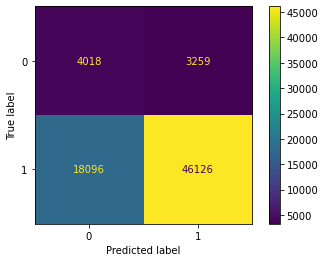

In [209]:
top_pipe.fit(X_un,y_un)
plot_confusion_matrix(top_pipe,X_un,y_un);

#### Comparing the best smote model to a non-smote model it is clear that the predictions of a non-smote has high bias and should not be used.

In [208]:
top_pipe_no_smote = Pipeline([
       #('vect', CountVectorizer(analyzer='word',stop_words = sw)),
       ('tfidf', TfidfVectorizer(analyzer='char', max_features=5000,lowercase=False,ngram_range = (2,3))),
#        ('smote', SMOTE(random_state=42,k_neighbors = 3)),
       ('mnb', naive_bayes.MultinomialNB(alpha = 0.1))])

In [210]:
param3 = {'mnb__alpha': [0.1],
 #'smote__k_neighbors': [3],
 'tfidf__analyzer': ['char'],
 'tfidf__ngram_range': [(2, 3)]}

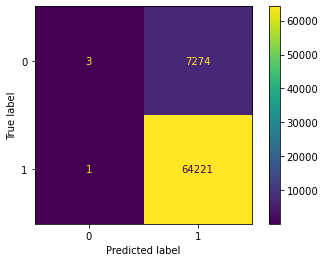

In [213]:
top_pipe_no_smote.fit(X_un,y_un)
plot_confusion_matrix(top_pipe_no_smote, X_un, y_un);

# NOT USED

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(body)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)


xvalid_count =  count_vect.transform(valid_x)